---

layout: post
title: How to Use One Way ANOVA in Python

---

One way ANOVA (Analysis of Variance) is a technique for hypothesis testing. It is used to test whether the means of different group is really different. 

Okaaaaay.... 

But then for all of you that are not used with **Statistics**, there might be big question arise: "Why would we even need to test this hypothesis testing?"

![but_why](https://media.giphy.com/media/1M9fmo1WAFVK0/giphy.gif)

Let me explain really quickly. In real world, most of the time we can only take samples of quantitative data. Say that I conduct a simple survey, I want to know the height of people in a town with population 10 million, and I could only ask 100 people.

Now, I take the first survey and got 100 people data, it shows that the average of people's height in the town are 170cm for men and 165cm for women. But somehow I want to re-do the survey in next day


Then I re-do the survey (assumes that I don't have the same person in with previous survey) and suprisingly it shows that the average of people's height in the town are 165cm for men and 165cm for women. Okay, now I am confused. 

![what](https://media.giphy.com/media/SqmkZ5IdwzTP2/giphy.gif)

Sooooo.. do men and women have same height in this town? 

This is it! It's time to use statistics that you all have learnt!


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import numpy as np

/home/arie/miniconda2/envs/data_analysis_351/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# don't ask about this, it's just happens to be a good style!
plt.style.use('fivethirtyeight')

## The Hypothesis
For this toy problem purpose, I have a hypothesis that
> for each diets, people weight's mean is same.



## Load The Data

Here I am using the **Diet Dataset** (see [here](https://www.sheffield.ac.uk/mash/statistics2/anova) for more datasets) from University of Sheffield for this practice problem. From the description [here](https://bioinformatics-core-shared-training.github.io/linear-models-r/r-recap.nb.html), the gender is binary variable which contains 0 for Female and 1 for Male. 

In [74]:
data = pd.read_csv('https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv')

## Getting Sense of The Dataset

In [75]:
data.head()

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3


In [76]:
print('This dataset contains {} rows'.format(data.size))

This dataset contains 546 rows


## See If There is Any Missing Values

In [77]:
data.gender.unique()

array([' ', '0', '1'], dtype=object)

In [78]:
# show which person have missing value in gender
data[data.gender == ' ']

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0


In [79]:
print('Missing value percentage of all data: {:.2f}%'.format(data[data.gender == ' '].size / data.size * 100))

Missing value percentage of all data: 2.56%


Cool! we only have ~3% missing value, either we could ignore, delete, or classify it's gender by using the closest Height mean.

## Getting the Sense of the Height Distribution

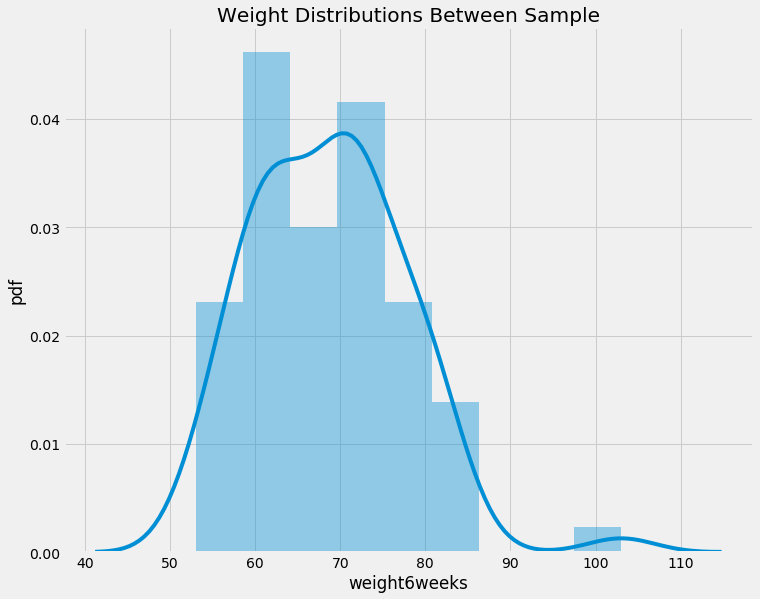

In [80]:
f, ax = plt.subplots(figsize=(11,9))
plt.title('Weight Distributions Between Sample')
plt.ylabel('pdf')
sns.distplot(data.weight6weeks)

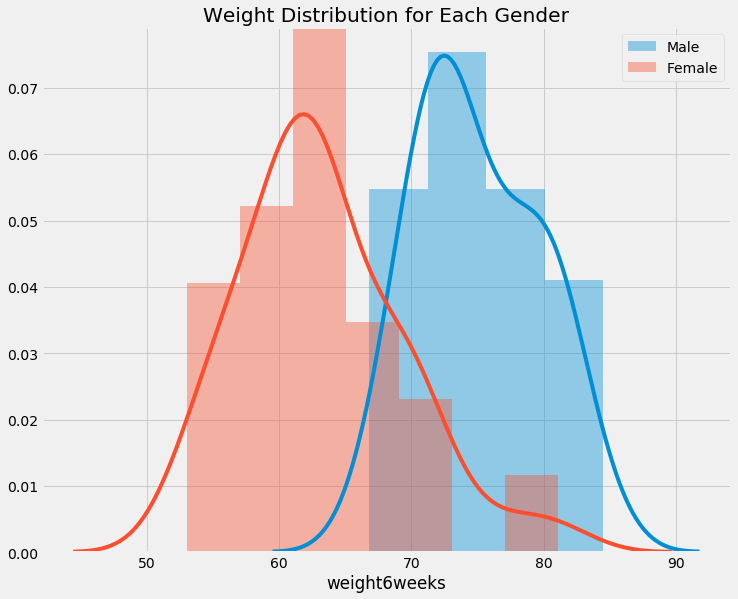

In [81]:
f, ax = plt.subplots(figsize=(11,9))
sns.distplot(data[data.gender == '1'].weight6weeks, ax=ax, label='Male')
sns.distplot(data[data.gender == '0'].weight6weeks, ax=ax, label='Female')
plt.title('Weight Distribution for Each Gender')
plt.legend()

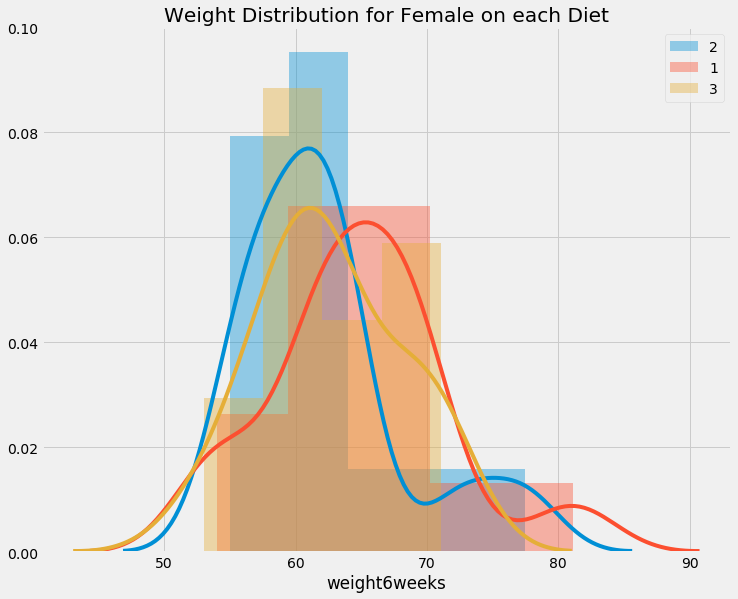

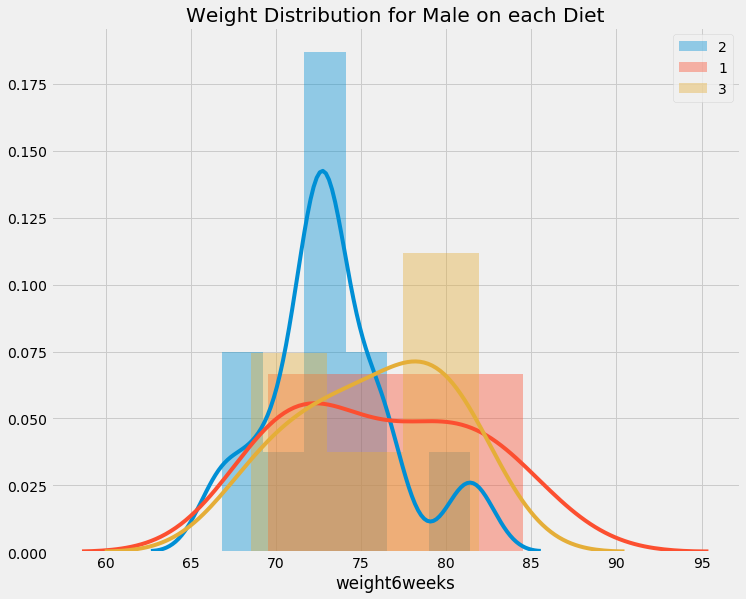

In [85]:
def infer_gender(x):
    if x == '1': 
        return 'Male'
    
    if x == '0':
        return 'Female'
    
    return 'Other'

def show_distribution(df, gender, column, group):
    f, ax = plt.subplots(figsize=(11,9))
    plt.title('Weight Distribution for {} on each {}'.format(gender, column))
    for group_member in group:
        sns.distplot(df[df[column] == group_member].weight6weeks, label='{}'.format(group_member))
    plt.legend()
    plt.show()
    
unique_diet = data.Diet.unique()
unique_gender = data.gender.unique()

for gender in unique_gender:
    if gender != ' ':
        show_distribution(data[data.gender == gender], infer_gender(gender), 'Diet', unique_diet)


In [89]:
data.groupby('gender').agg(
    [np.mean, np.median, np.count_nonzero, np.std]
).weight6weeks

,mean,median,count_nonzero,std
gender,,,,
,81.500000,81.5,2.0,30.405592
0,63.223256,62.4,43.0,6.150874
1,75.015152,73.9,33.0,4.629398


In [88]:
data.groupby(['gender', 'Diet']).agg(
    [np.mean, np.median, np.count_nonzero, np.std]
).weight6weeks

mean  median  count_nonzero        std
gender Diet                                             
       2     81.500000   81.50            2.0  30.405592
0      1     64.878571   64.50           14.0   6.877296
       2     62.178571   61.15           14.0   6.274635
       3     62.653333   61.80           15.0   5.370537
1      1     76.150000   75.75           10.0   5.439414
       2     73.163636   72.70           11.0   3.818448
       3     75.766667   76.35           12.0   4.434848

We can see difference in weight on females in diet, but interestingly, it does not seems to affect males. LOL

![expected](https://media.giphy.com/media/L20mbc7yRfsly/giphy.gif)



**Next question is: will the population behave the same?**


## The 1 Way Anova

The 1 way anova's null hypothesis is
$$\mu_{weight_{diet1}} = \mu_{weight_{diet2}} = \mu_{weight_{diet3}}$$

and this tests tries to see if it is true or not true

let's assume that we have initially determine our confidence level of 95%, which means that we will accept 5% error rate.

In [47]:
mod = ols('Height ~ Diet', data=data[data.gender=='0']).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for Female')
print('----------------------')
print(aov_table)
print()


mod = ols('Height ~ Diet', data=data[data.gender=='1']).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for Male')
print('----------------------')
print(aov_table)

ANOVA table for Female
----------------------
               sum_sq    df        F    PR(>F)
Diet       559.680764   1.0  7.17969  0.010566
Residual  3196.086677  41.0      NaN       NaN

ANOVA table for Male
----------------------
               sum_sq    df        F    PR(>F)
Diet        67.801603   1.0  0.43841  0.512784
Residual  4794.259003  31.0      NaN       NaN


There are two p-values(PR(>F)) that we can see here, male and female. 

For male, we cannot accept the null hypothesis under 95% confident level, because the p-value is greater than our alpha (0.05 < 0.512784). So given these three type of diet, there are no difference in male weights.

![i_know](https://media.giphy.com/media/QzKtmrdMw6Tra/giphy.gif)


For female, since the p-value PR(>F) is less than our error rate (0.05 > 0.010566), we could reject the null hypothesis. This means we are quite confident that **there is a different in height for Female in diets**. 

Okay so we know the effect of diet in female, but we don't know which diet is different from which. We have to do post-hoc analysis using Tukey HSD (Honest Significant Difference) Test.

In [86]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [52]:
# Only use female data
df = data[data.gender=='0']

# compare the height between each diet, using 95% confidence interval 
mc = MultiComparison(df['Height'], df['Diet'])
tukey_result = mc.tukeyhsd(alpha=0.05)

print(tukey_result)
print('Unique diet groups: {}'.format(mc.groupsunique))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1      2    -3.5714  -11.7861  4.6432 False 
  1      3    -8.7714  -16.848  -0.6948  True 
  2      3      -5.2   -13.2766  2.8766 False 
----------------------------------------------
Unique diet groups: [1 2 3]


We can only reject the null hypothesis between diet type 1 and diet type 3, means there is statistically significant difference in weight for diet 1 and diet 3.

# References:
- https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html
- http://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html
- https://www.sheffield.ac.uk/mash/statistics2/anova
- https://stackoverflow.com/questions/16049552/what-statistics-module-for-python-supports-one-way-anova-with-post-hoc-tests-tu
